# NPZD model

 * The variables $N$, $P$, $Z$, and $D$ denote the concentrations of nutrients, phytoplankton, zooplankton, and detritus in the model, respectively. For convenience, the four variables are often merged into a state vector `x`.
 * The following system of ordinary differential equations (ODEs) describe the model dynamics and are included in the code below.
$$
\begin{alignat*}{5}
	\frac{\partial{}N}{\partial{}t} &=& -\theta_\texttt{vmax}\;\frac{N}{N+\theta_\texttt{nuthalfsat}}\;P &\;&        &\;&\;&\;&\; &\;& +\theta_\texttt{remin}\;D \nonumber \\
	\frac{\partial{}P}{\partial{}t} &=&  \theta_\texttt{vmax}\;\frac{N}{N+\theta_\texttt{nuthalfsat}}\;P &\;& -\theta_\texttt{graz}\;P\;Z &\;& -\theta_\texttt{mortP}\;P &\;& &\;& \nonumber \\
	\frac{\partial{}Z}{\partial{}t} &=& &\;&  \theta_\texttt{graz}\;P\;Z &\;& &\;& -\theta_\texttt{mortZ}\;Z^{2} &\;& \nonumber \\
    \frac{\partial{}D}{\partial{}t} &=& &\;& &\;& \theta_\texttt{mortP}\;P &\;& +\theta_\texttt{mortZ}\;Z^{2} &\;& -\theta_\texttt{remin}\;D \nonumber
\end{alignat*}
$$

In [1]:
import numpy as np

# parameter values
parameters = {
    'vmax': 0.075,       # maximum growth rate in Michaelis Menten formulation
    'nuthalfsat': 0.3,   # nutrient half saturation in Michaelis Menten formulation
    'graz': 0.02,        # zooplankton grazing rate
    'mortP': 0.02,       # phytoplankton mortality rate
    'mortZ': 0.03,       # zooplankton mortality rate
    'reminrate': 0.1,    # remineralization rate
}

# model
def npzd(x, t, parameters, light):
    '''
    input
    =====
    x: model state
    t: current time (in days)
    parameters: model parameters
    light: light function returning irradiance at time t
    '''
    n, p, z, d = np.maximum(x, 0.0)

    growth = parameters['vmax'] * n / (parameters['nuthalfsat'] + n) * light(t) * p
    grazing = parameters['graz'] * p * z
    p_loss = parameters['mortP'] * p
    z_loss = parameters['mortZ'] * z * z
    remin = parameters['reminrate'] * d

    return np.array((-growth+remin, growth-grazing-p_loss, grazing-z_loss, p_loss+z_loss-remin))

In [2]:
from scipy.integrate import odeint

# initial conditions
x0 = np.array((0.6, 0.15, 0.2, 0.05))

# initialize time vector (2 years)
t = np.arange(0.0, 2 * 365.0, 1.0)

# light function returning irradiance at time t
def light(t):
    return 1.0 + 0.5*(0.8 * np.sin(np.pi*((t-81.25)/182.5)) - 0.8)

x = odeint(npzd, x0, t, args=(parameters, light))

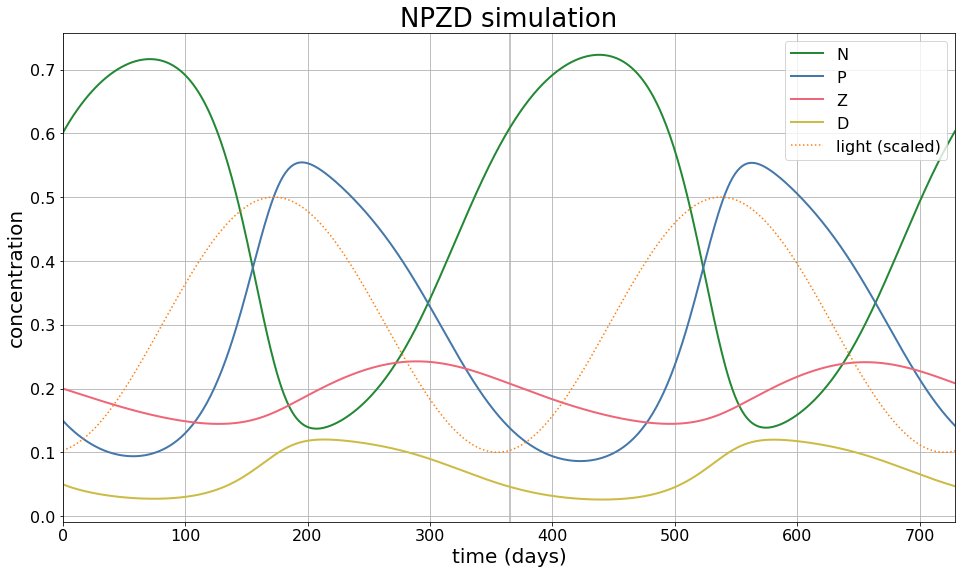

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['figure.figsize'] = (16, 9)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['font.size'] = 20

colors = ('#228833', '#4477AA', '#EE6677', '#CCBB44') # colorblind-friendly colors for N, P, Z, D

fig, ax = plt.subplots()
for i,name in enumerate(('N','P','Z', 'D')):
    ax.plot(t, x[:,i], color=colors[i], label=name, lw=2)
ax.axvline(365, color='0.7', zorder=0)
ax.plot(t, 0.5 * light(t), linestyle=':', color='#ff7f0e', label='light (scaled)')
ax.set(title='NPZD simulation', xlabel='time (days)', ylabel='concentration', xlim=(t[0], t[-1]))
ax.grid(True)
ax.legend()

None